In [9]:
import jax.numpy as np
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
config.update("jax_enable_x64", True)
import pandas as pd
plt.rcParams.update({'font.size': 12})

import pandas as pd
from sklearn.metrics import r2_score

We have first three types of tests
* strip x
* strip y 
* equibiaxial 

All cases assume fully incompressible plane-stress behavior. For all cases $\sigma_x$ and $\sigma_y$ is given, so the loss is completely based on those values. 

Rough estimate of the normalization factors: 
$lambda_x$ and $\lambda_y$ are in the range $[1,1.5]$ which means that even for equibiaxial the maximum range for the invariants is going to be $I_1 \in [3,5]$ and $I_2 \in [3,6]$ 

On the other hand, the Cauchy stresses are in the range $[0,1]$ MPa 

Considering the expression for the stress of the form $\sigma = \Psi_1 \mathbf{b} + \Psi_2(I_1\mathbf{b}-\mathbf{b}^2) + \Psi_{4a}\mathbf{a}_0 \otimes \mathbf{a}_0 + \Psi_{4s}\mathbf{s}_0 \otimes \mathbf{s}_0 $ then each of the derivatives has to be inside the ranges $\Psi_1 \in [0,0.6]$, $\Psi_2 \in [0,0.46]$, $\Psi_{4a},\Psi_{4s} \in [0,1]$. So based on that we can normalize approximately. Should not be a problem even without normalizing as the ranges are ok. Even in the extreme of $I_2$ being compressed from $[3,6]$ down to 0 I think this is still ok. 

In [10]:
with open('Data/P12AC1_bsxsy.npy', 'rb') as f:
    lamb, sigma = np.load(f,allow_pickle=True)
lamb = lamb.astype(np.float64)
sigma = sigma.astype(np.float64)
ind_sx = 81
ind_sy = 182
lamb_sigma = np.hstack([lamb,sigma])

In [3]:
## Doing with an object 'model' I still like that 
def eval_Cauchy(lambx,lamby, model, normalization):
    # all normalization constants 
    I1_factor  = normalization[0]
    I2_factor  = normalization[1]
    I4a_factor = normalization[2]
    I4s_factor = normalization[3]
    Psi1_factor = normalization[4]
    Psi2_factor = normalization[5]
    Psi4a_factor = normalization[6]
    Psi4s_factor = normalization[7]
    Psi_1_2_factor = normalization[8]
    Psi_1_4a_factor = normalization[9]
    Psi_1_4s_factor = normalization[10]
    Psi_2_4a_factor = normalization[11]
    Psi_2_4s_factor = normalization[12]
    Psi_4a_4s_factor = normalization[13]
    # I dont want to assemble F, C, etc because not vector friendly 
    # but all these deformations are diagonal so we can compute invariants easily
    # even without explicitly computing the F, C, etc 
    # need to check it but it should be like this: 
    I1 = lambx**2+lamby**2+(1./(lambx*lamby)**2)
    I2 = lambx**2*lamby**2 + lambx**2*(1./(lambx*lamby)**2) + lamby**2*(1./(lambx*lamby)**2) 
    I4a = lambx**2
    I4s = lamby**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    I4anorm = (I4a-1)/I4a_factor
    I4snorm = (I4s-1)/I4s_factor
    # calling all the NODE predictions and undoing normalization 
    # single variable terms 
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    Psi4a = 0#model.Psi4anorm(I4anorm)*Psi4a_factor
    Psi4s = 0#model.Psi4snorm(I4snorm)*Psi4s_factor
    # ignore mixed terms 
    Psi_1_2 = 0#model.Psi_1_2_norm(I1norm,I2norm)*Psi_1_2_factor
    Psi_2_1 = 0#model.Psi_2_1_norm(I1norm,I2norm)*Psi_1_2_factor
    Psi_1_4a = model.Psi_1_4a_norm(I1norm,I4anorm)*Psi_1_4a_factor
    Psi_4a_1 = model.Psi_4a_1_norm(I1norm,I4anorm)*Psi_1_4a_factor
    Psi_1_4s = model.Psi_1_4s_norm(I1norm,I4snorm)*Psi_1_4s_factor
    Psi_4s_1 = model.Psi_4s_1_norm(I1norm,I4snorm)*Psi_1_4s_factor
    Psi_2_4a = 0#model.Psi_2_4a_norm(I2norm,I4anorm)*Psi_2_4a_factor
    Psi_4a_2 = 0#model.Psi_4a_2_norm(I2norm,I4anorm)*Psi_2_4a_factor
    Psi_2_4s = 0#model.Psi_2_4s_norm(I2norm,I4snorm)*Psi_2_4s_factor
    Psi_4s_2 = 0#model.Psi_4s_2_norm(I2norm,I4snorm)*Psi_2_4s_factor
    Psi_4a_4s = model.Psi_4a_4s_norm(I4anorm,I4snorm)*Psi_4a_4s_factor
    Psi_4s_4a = model.Psi_4s_4a_norm(I4anorm,I4snorm)*Psi_4a_4s_factor
    
    # get pressure from sigma_33 = 0 
    lambz = 1./(lambx*lamby)
    p = (Psi1+Psi_2_1+Psi_4a_1+Psi_4s_1)*lambz**2 + (Psi2+Psi_1_2+Psi_4a_2+Psi_4s_2)*(I1*lambz**2 - lambz**4) 
    sigx = (Psi1+Psi_2_1+Psi_4a_1+Psi_4s_1)*lambx**2 + (Psi2+Psi_1_2+Psi_4a_2+Psi_4s_2)*(I1*lambx**2 - lambx**4) \
            + (Psi4a+Psi_1_4a+Psi_2_4a+Psi_4s_4a)*lambx**2 - p
    sigy = (Psi1+Psi_2_1+Psi_4a_1+Psi_4s_1)*lamby**2 + (Psi2+Psi_1_2+Psi_4a_2+Psi_4s_2)*(I1*lamby**2 - lamby**4) \
            + (Psi4s+Psi_1_4s+Psi_2_4s+Psi_4a_4s)*lamby**2 - p
    return sigx,sigy

def plotstresses(x_gt,sgmx_gt,sgmy_gt,x_pr,sgmx_pr, sgmy_pr):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    labels = ['UT', 'ET', 'PS']
    for axi, x_gti, sgmx_gti, sgmy_gti, x_pri, sgmx_pri, sgmy_pri, label in zip(ax, x_gt, sgmx_gt, sgmy_gt, x_pr, sgmx_pr, sgmy_pr, labels):
        axi.plot(x_gti, sgmx_gti, 'k.')
        axi.plot(x_pri, sgmx_pri, 'k-')
    
        axi.plot(x_gti, sgmy_gti, 'b.')
        axi.plot(x_pri, sgmy_pri, 'b-')

        axi.set_title(label)
        axi.set_xlabel(r'Stretch $\lambda [-]$')
        axi.set_ylabel(r'Cauchy stress $\sigma [MPa]$')
    return fig, ax

## Define all 3 models

In [4]:
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        # self.params_I4a = params_I4a
        # self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
    
    def Psi1norm(self, I1norm):
        return NODE_vmap(I1norm, self.params_I1)
    
    def Psi2norm(self, I2norm):
        return NODE_vmap(I2norm, self.params_I2)
    
    # def Psi4anorm(self, I4anorm):
    #     return NODE_vmap(I4anorm, self.params_I4a)
    
    # def Psi4snorm(self, I4snorm):
    #     return NODE_vmap(I4snorm, self.params_I4s)
    
    def Psi_2_1_norm(self, I1norm, I2norm):
        alpha = self.params_I1_I2[-1]
        K = alpha*(I1norm) + (1-alpha)*(I2norm)
        return alpha*NODE_vmap(K, self.params_I1_I2[:-1])
    
    def Psi_1_2_norm(self, I1norm, I2norm):
        alpha = self.params_I1_I2[-1]
        K = alpha*(I1norm) + (1-alpha)*(I2norm)
        return (1-alpha)*NODE_vmap(K, self.params_I1_I2[:-1])
    
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        return alpha*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        return alpha*NODE_vmap(K, self.params_I1_I4s[:-1])
    
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4s[:-1])

    def Psi_4a_2_norm(self, I2norm, I4anorm):
        alpha = self.params_I2_I4a[-1]
        K = alpha*(I2norm ) + (1-alpha)*(I4anorm )
        return alpha*NODE_vmap(K, self.params_I2_I4a[:-1])
    
    def Psi_2_4a_norm(self, I2norm, I4anorm):
        alpha = self.params_I2_I4a[-1]
        K = alpha*(I2norm ) + (1-alpha)*(I4anorm )
        return (1-alpha)*NODE_vmap(K, self.params_I2_I4a[:-1])
    
    def Psi_4s_2_norm(self, I2norm, I4snorm):
        alpha = self.params_I2_I4s[-1]
        K = alpha*(I2norm ) + (1-alpha)*(I4snorm )
        return alpha*NODE_vmap(K, self.params_I2_I4s[:-1])
    
    def Psi_2_4s_norm(self, I2norm, I4snorm):
        alpha = self.params_I2_I4s[-1]
        K = alpha*(I2norm ) + (1-alpha)*(I4snorm )
        return (1-alpha)*NODE_vmap(K, self.params_I2_I4s[:-1])
    
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm )
        return alpha*NODE_vmap(K, self.params_I4a_I4s[:-1])
    
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm)
        return (1-alpha)*NODE_vmap(K, self.params_I4a_I4s[:-1])

# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        # self.params_I4a = params_I4a
        # self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
        self.normalization = normalization
        
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the sigma functions expect the gradient so taking derivative
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df1 = grad(f1)
        return vmap(df1)(I1norm[:,None])[:,0]/self.normalization[0]
    
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df2 = grad(f2)
        return vmap(df2)(I2norm[:,None])[:,0]/self.normalization[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*alpha/self.normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*(1-alpha)/self.normalization[2]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*alpha/self.normalization[0]
    
    # mixed term with I4s and I1
    # output is derivative wrt I4s
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*(1-alpha)/self.normalization[3]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4a
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*alpha/self.normalization[2]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm )
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*(1-alpha)/self.normalization[3]

class CANN_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        # self.params_I4a = params_I4a
        # self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
        self.normalization = normalization
    
    # Psi1
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1norm,self.params_I1)[:,0]/normalization[0]
    
    # Psi2
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2norm,self.params_I2)[:,0]/normalization[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*alpha/normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*(1-alpha)/normalization[2]
    
    # mixed term with I4s and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*alpha/normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*(1-alpha)/normalization[3]
    
    # mixed term with I4s and I4a
    # output is derivative wrt I4a
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*alpha/normalization[2]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*(1-alpha)/normalization[3]
    

In [5]:
I1_factor = 5
I2_factor = 7
I4a_factor = 2
I4s_factor = 2
Psi1_factor = 0.5
Psi2_factor = 0.5
Psi4a_factor = 0.5
Psi4s_factor = 0.5
Psi_1_2_factor = 0.5
Psi_1_4a_factor = 0.5
Psi_1_4s_factor = 0.5
Psi_2_4a_factor = 0.5
Psi_2_4s_factor = 0.5
Psi_4a_4s_factor = 0.5
normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,\
                 Psi1_factor,Psi2_factor,Psi4a_factor,Psi4s_factor,\
                 Psi_1_2_factor,Psi_1_4a_factor,Psi_1_4s_factor,\
                 Psi_2_4a_factor,Psi_2_4s_factor, Psi_4a_4s_factor]

@partial(jit, static_argnums=(2,))
def loss_sig_all(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[:,0]
    lamby = lamb_sigma[:,1]
    sigmax = lamb_sigma[:,2]
    sigmay = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_e(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[:ind_sx,0]
    lamby = lamb_sigma[:ind_sx,1]
    sigmax = lamb_sigma[:ind_sx,2]
    sigmay = lamb_sigma[:ind_sx,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_sx(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[ind_sx:ind_sy,0]
    lamby = lamb_sigma[ind_sx:ind_sy,1]
    sigmax = lamb_sigma[ind_sx:ind_sy,2]
    sigmay = lamb_sigma[ind_sx:ind_sy,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_sy(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[ind_sy:,0]
    lamby = lamb_sigma[ind_sy:,1]
    sigmax = lamb_sigma[ind_sy:,2]
    sigmay = lamb_sigma[ind_sy:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(0,1,))
def step_jp(loss, mdlnumber, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, mdlnumber)
    return opt_update(i, g, opt_state)

def train_jp(loss, mdlnumber, X, opt_state, key, nIter = 10000, print_freq=1000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, mdlnumber, it, opt_state, X)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, mdlnumber)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

#cann:
n_params_cann = 5*12 = 60
n_params_icnn = 5*(4 + 12*2 + 3*2) = 5*34 = 170 #Use layers= [1,4,3,1] for icnn
n_params_node = 5*(5 + 25 + 5) = 175 #Use layers = [1,5,5,1]

[1,2,3,1]

What if we use [1,2,3,1] for node? Then use [1,4,1] for icnn
n_params_cann = 5*12 = 60
n_params_node = 5*(2+6+3) = 55
n_params_icnn = 5*(4+2*4) = 60

In [6]:
def init_node(key, layers=[1,5,5,1]):
    key, subkey = random.split(key)
    params_I1 = init_params(layers, key)
    params_I2 = init_params(layers, key)
    params_I4a=[0.0]
    params_I4s=[0.0]
    params_I1_I2=[0.0]
    params_I1_I2.append(0.0)
    params_I1_I4a = init_params(layers, key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params(layers, key)
    params_I1_I4s.append(0.5)
    params_I2_I4a=[0.0]
    params_I2_I4a.append(0.0)
    params_I2_I4s=[0.0]
    params_I2_I4s.append(0.0)
    params_I4a_I4s = init_params(layers, key)
    params_I4a_I4s.append(0.5)

    return [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s], key

def init_icnn(key, layers=[1,4,3,1]):
    key, subkey = random.split(key)
    params_I1 = init_params_icnn(layers, key)
    params_I2 = init_params_icnn(layers, key)
    params_I4a=[0.0]
    params_I4s=[0.0]
    params_I1_I2=[0.0]
    params_I1_I2.append(0.0)
    params_I1_I4a = init_params_icnn(layers, key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params_icnn(layers, key)
    params_I1_I4s.append(0.5)
    params_I2_I4a=[0.0]
    params_I2_I4a.append(0.0)
    params_I2_I4s=[0.0]
    params_I2_I4s.append(0.0)
    params_I4a_I4s = init_params_icnn(layers, key)
    params_I4a_I4s.append(0.5)

    return [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                    params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s], key

def init_cann(key, layers=None):
    key, subkey = random.split(key)
    params_I1 = init_params_cann(key)
    params_I2 = init_params_cann(key)
    params_I4a=[0.0]
    params_I4s=[0.0]
    params_I1_I2=[0.0]
    params_I1_I2.append(0.0)
    params_I1_I4a = init_params_cann(key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params_cann(key)
    params_I1_I4s.append(0.5)
    params_I2_I4a=[0.0]
    params_I2_I4a.append(0.0)
    params_I2_I4s=[0.0]
    params_I2_I4s.append(0.0)
    params_I4a_I4s = init_params_cann(key)
    params_I4a_I4s.append(0.5)

    return [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                    params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s], key

## Train NODE

In [8]:
lamb_sigma.shape

(254, 4)

In [ ]:
params_a, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_a)
mdlnumber = 3
params_a, train_loss, val_loss = train_jp(loss_sig_all, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000) #Original 100000

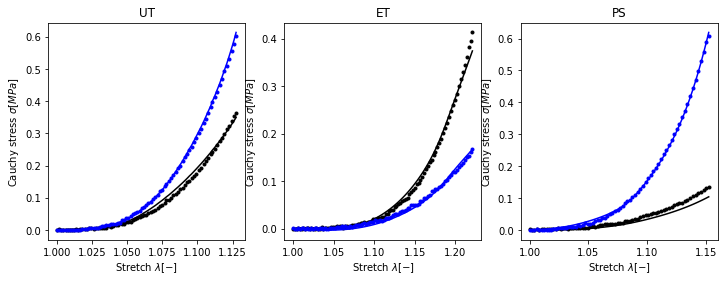

In [10]:
model = NODE_model(*params_a)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [9]:
# save the result with pickle
with open('savednet/NODE_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_a, f)

In [42]:
params_e, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_e)
mdlnumber = 3
params_e, train_loss, val_loss = train_jp(loss_sig_e, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 4.641122e-03
it 2000, train loss = 2.147657e-03
it 3000, train loss = 1.560942e-03
it 4000, train loss = 1.254631e-03
it 5000, train loss = 1.040208e-03
it 6000, train loss = 8.722781e-04
it 7000, train loss = 7.213356e-04
it 8000, train loss = 1.429694e-04
it 9000, train loss = 7.324379e-05
it 10000, train loss = 4.258205e-05
it 11000, train loss = 3.607185e-05
it 12000, train loss = 3.382938e-05
it 13000, train loss = 3.186234e-05
it 14000, train loss = 3.010977e-05
it 15000, train loss = 2.854477e-05
it 16000, train loss = 2.700195e-05
it 17000, train loss = 2.312648e-05
it 18000, train loss = 1.600368e-05
it 19000, train loss = 9.946552e-06
it 20000, train loss = 6.976497e-06
it 21000, train loss = 6.660599e-06
it 22000, train loss = 6.486249e-06
it 23000, train loss = 6.364130e-06
it 24000, train loss = 6.272626e-06
it 25000, train loss = 6.200360e-06
it 26000, train loss = 6.141019e-06
it 27000, train loss = 6.089305e-06
it 28000, train loss = 6.043262e-06
i

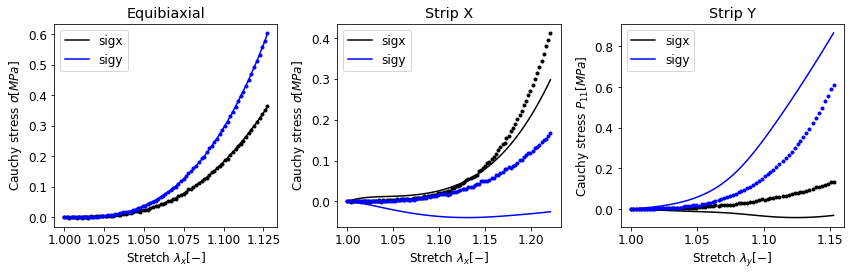

In [45]:
model = NODE_model(*params_e)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [47]:
# save the result with pickle
with open('savednet/NODE_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_e, f)

In [49]:
params_sx, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_sx)
mdlnumber = 3
params_sx, train_loss, val_loss = train_jp(loss_sig_sx, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 1.909258e-03
it 2000, train loss = 9.758081e-04
it 3000, train loss = 6.503147e-04
it 4000, train loss = 5.333755e-04
it 5000, train loss = 4.886772e-04
it 6000, train loss = 4.656070e-04
it 7000, train loss = 4.512025e-04
it 8000, train loss = 4.411203e-04
it 9000, train loss = 4.314397e-04
it 10000, train loss = 3.955104e-04
it 11000, train loss = 9.170463e-05
it 12000, train loss = 8.864811e-05
it 13000, train loss = 3.188999e-05
it 14000, train loss = 2.784729e-05
it 15000, train loss = 2.708347e-05
it 16000, train loss = 2.572558e-05
it 17000, train loss = 2.267424e-05
it 18000, train loss = 1.932704e-05
it 19000, train loss = 1.799222e-05
it 20000, train loss = 1.766728e-05
it 21000, train loss = 1.748084e-05
it 22000, train loss = 1.730733e-05
it 23000, train loss = 1.721282e-05
it 24000, train loss = 1.716290e-05
it 25000, train loss = 1.713193e-05
it 26000, train loss = 1.710726e-05
it 27000, train loss = 1.708498e-05
it 28000, train loss = 1.706466e-05
i

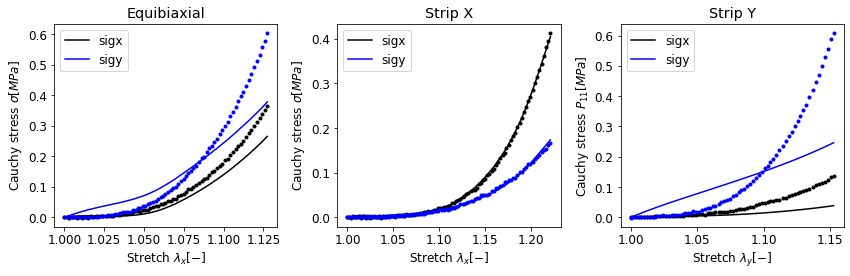

In [50]:
model = NODE_model(*params_sx)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [52]:
# save the result with pickle
with open('savednet/NODE_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_sx, f)

In [54]:
params_sy, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_sy)
mdlnumber = 3
params_sy, train_loss, val_loss = train_jp(loss_sig_sy, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 5.530217e-03
it 2000, train loss = 2.853526e-03
it 3000, train loss = 1.432703e-03
it 4000, train loss = 9.060081e-04
it 5000, train loss = 6.522694e-04
it 6000, train loss = 5.030478e-04
it 7000, train loss = 4.111225e-04
it 8000, train loss = 3.537705e-04
it 9000, train loss = 3.173145e-04
it 10000, train loss = 2.925386e-04
it 11000, train loss = 2.725842e-04
it 12000, train loss = 2.538892e-04
it 13000, train loss = 2.187695e-04
it 14000, train loss = 1.681792e-04
it 15000, train loss = 1.600816e-04
it 16000, train loss = 1.307289e-04
it 17000, train loss = 4.481874e-05
it 18000, train loss = 4.300245e-05
it 19000, train loss = 4.066743e-05
it 20000, train loss = 3.705761e-05
it 21000, train loss = 3.160884e-05
it 22000, train loss = 2.472157e-05
it 23000, train loss = 1.850728e-05
it 24000, train loss = 1.416814e-05
it 25000, train loss = 1.183375e-05
it 26000, train loss = 1.052789e-05
it 27000, train loss = 9.714161e-06
it 28000, train loss = 9.163805e-06
i

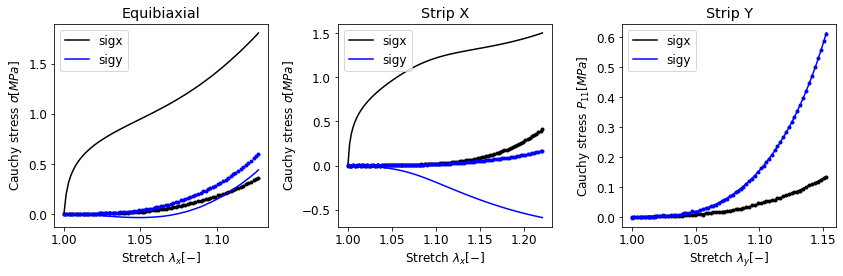

In [55]:
model = NODE_model(*params_sy)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [57]:
# save the result with pickle
with open('savednet/NODE_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_sy, f)

## Train ICNN

In [7]:
params_icnn_all, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_all)
mdlnumber = 2
params_icnn_all, train_loss, val_loss = train_jp(loss_sig_all, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000) #Original 100000

it 1000, train loss = 2.523965e-02
it 2000, train loss = 1.865044e-02
it 3000, train loss = 1.590344e-02
it 4000, train loss = 1.207996e-02
it 5000, train loss = 8.664019e-03
it 6000, train loss = 7.377584e-03
it 7000, train loss = 4.969973e-03
it 8000, train loss = 4.230087e-03
it 9000, train loss = 3.239028e-03
it 10000, train loss = 1.677134e-03
it 11000, train loss = 1.353595e-03
it 12000, train loss = 1.211091e-03
it 13000, train loss = 1.086397e-03
it 14000, train loss = 9.321909e-04
it 15000, train loss = 7.713421e-04
it 16000, train loss = 5.901278e-04
it 17000, train loss = 4.006143e-04
it 18000, train loss = 3.212855e-04
it 19000, train loss = 3.038797e-04
it 20000, train loss = 2.982155e-04
it 21000, train loss = 2.938088e-04
it 22000, train loss = 2.893363e-04
it 23000, train loss = 2.846698e-04
it 24000, train loss = 2.799419e-04
it 25000, train loss = 2.752147e-04
it 26000, train loss = 2.705772e-04
it 27000, train loss = 2.661333e-04
it 28000, train loss = 2.619837e-04
i

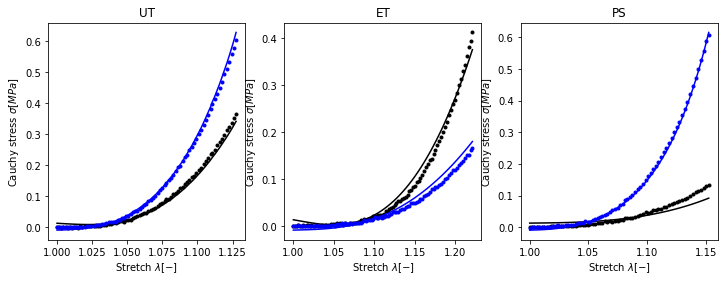

In [8]:
model = ICNN_model(*params_icnn_all,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [9]:
# save the result with pickle
with open('savednet/ICNN_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_icnn_all, f)

In [10]:
params_icnn_e, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_e)
mdlnumber = 2
params_icnn_e, train_loss, val_loss = train_jp(loss_sig_e, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 1.080993e-01
it 2000, train loss = 2.923280e-02
it 3000, train loss = 1.941601e-02
it 4000, train loss = 1.385354e-02
it 5000, train loss = 1.049368e-02
it 6000, train loss = 7.729593e-03
it 7000, train loss = 6.978354e-03
it 8000, train loss = 6.773073e-03
it 9000, train loss = 6.577976e-03
it 10000, train loss = 6.271861e-03
it 11000, train loss = 5.492459e-03
it 12000, train loss = 3.777376e-03
it 13000, train loss = 2.960100e-03
it 14000, train loss = 6.517848e-04
it 15000, train loss = 2.019585e-04
it 16000, train loss = 1.950539e-04
it 17000, train loss = 1.853244e-04
it 18000, train loss = 1.724787e-04
it 19000, train loss = 1.552562e-04
it 20000, train loss = 1.025085e-04
it 21000, train loss = 1.225040e-05
it 22000, train loss = 9.637693e-06
it 23000, train loss = 9.286817e-06
it 24000, train loss = 8.975203e-06
it 25000, train loss = 8.697407e-06
it 26000, train loss = 8.454001e-06
it 27000, train loss = 8.240277e-06
it 28000, train loss = 8.063910e-06
i

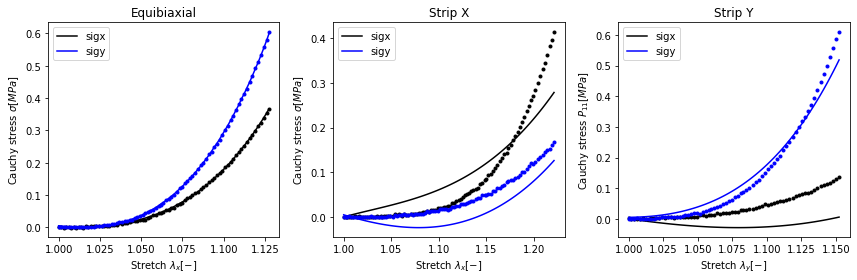

In [11]:
model = ICNN_model(*params_icnn_e,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [12]:
# save the result with pickle
with open('savednet/ICNN_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_icnn_e, f)

In [13]:
params_icnn_sx, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_sx)
mdlnumber = 2
params_icnn_sx, train_loss, val_loss = train_jp(loss_sig_sx, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 4.516178e-02
it 2000, train loss = 9.590145e-03
it 3000, train loss = 6.889461e-03
it 4000, train loss = 5.136428e-03
it 5000, train loss = 4.028962e-03
it 6000, train loss = 3.537414e-03
it 7000, train loss = 3.418126e-03
it 8000, train loss = 3.365359e-03
it 9000, train loss = 3.290713e-03
it 10000, train loss = 3.163473e-03
it 11000, train loss = 2.916225e-03
it 12000, train loss = 2.531315e-03
it 13000, train loss = 2.124869e-03
it 14000, train loss = 1.495441e-03
it 15000, train loss = 2.559369e-04
it 16000, train loss = 1.674352e-04
it 17000, train loss = 1.547733e-04
it 18000, train loss = 1.392599e-04
it 19000, train loss = 1.205254e-04
it 20000, train loss = 9.666871e-05
it 21000, train loss = 7.379140e-05
it 22000, train loss = 5.546745e-05
it 23000, train loss = 4.028617e-05
it 24000, train loss = 2.885962e-05
it 25000, train loss = 2.151033e-05
it 26000, train loss = 1.776213e-05
it 27000, train loss = 1.627112e-05
it 28000, train loss = 1.569648e-05
i

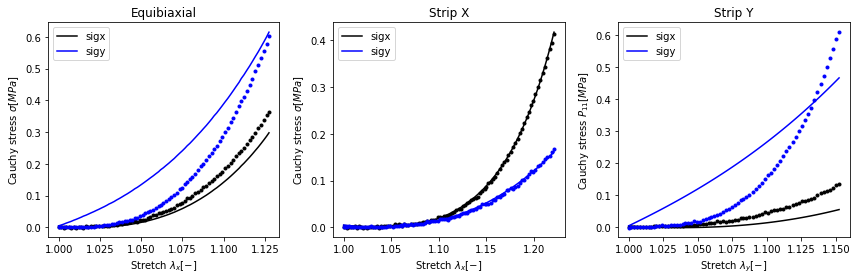

In [14]:
model = ICNN_model(*params_icnn_sx,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [15]:
# save the result with pickle
with open('savednet/ICNN_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_icnn_sx, f)

In [16]:
params_icnn_sy, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_sy)
mdlnumber = 2
params_icnn_sy, train_loss, val_loss = train_jp(loss_sig_sy, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 7.744813e-02
it 2000, train loss = 2.607965e-02
it 3000, train loss = 1.621639e-02
it 4000, train loss = 1.094850e-02
it 5000, train loss = 8.420518e-03
it 6000, train loss = 7.324534e-03
it 7000, train loss = 6.898591e-03
it 8000, train loss = 6.766720e-03
it 9000, train loss = 6.662199e-03
it 10000, train loss = 6.520385e-03
it 11000, train loss = 6.144184e-03
it 12000, train loss = 4.528040e-03
it 13000, train loss = 4.048220e-03
it 14000, train loss = 3.614235e-03
it 15000, train loss = 3.122333e-03
it 16000, train loss = 2.084272e-03
it 17000, train loss = 2.846041e-04
it 18000, train loss = 1.834192e-04
it 19000, train loss = 1.703255e-04
it 20000, train loss = 1.572089e-04
it 21000, train loss = 1.420076e-04
it 22000, train loss = 1.222213e-04
it 23000, train loss = 9.455672e-05
it 24000, train loss = 6.196801e-05
it 25000, train loss = 3.241197e-05
it 26000, train loss = 1.495640e-05
it 27000, train loss = 8.455588e-06
it 28000, train loss = 6.696893e-06
i

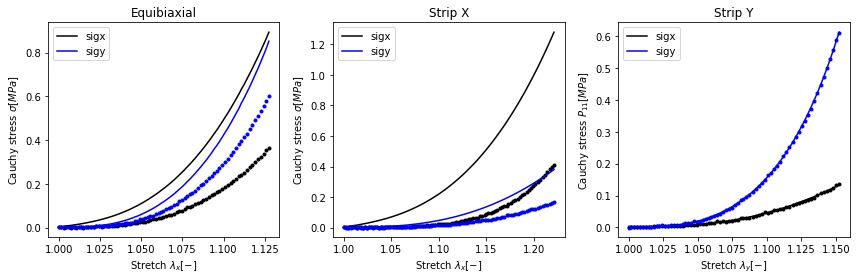

In [17]:
model = ICNN_model(*params_icnn_sy,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [18]:
# save the result with pickle
with open('savednet/ICNN_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_icnn_sy, f)

## CANN training

In [9]:
params_cann_all, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_all)
mdlnumber = 1
params_cann_all, train_loss, val_loss = train_jp(loss_sig_all, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 2.161802e-02
it 2000, train loss = 1.520018e-02
it 3000, train loss = 9.526620e-03
it 4000, train loss = 5.727521e-03
it 5000, train loss = 3.064262e-03
it 6000, train loss = 1.582786e-03
it 7000, train loss = 1.046179e-03
it 8000, train loss = 8.536047e-04
it 9000, train loss = 7.671835e-04
it 10000, train loss = 7.163296e-04
it 11000, train loss = 6.808059e-04
it 12000, train loss = 6.527314e-04
it 13000, train loss = 6.302902e-04
it 14000, train loss = 6.133200e-04
it 15000, train loss = 5.999768e-04
it 16000, train loss = 5.848080e-04
it 17000, train loss = 5.630020e-04
it 18000, train loss = 5.396076e-04
it 19000, train loss = 5.222883e-04
it 20000, train loss = 5.103332e-04
it 21000, train loss = 4.995324e-04
it 22000, train loss = 4.896288e-04
it 23000, train loss = 4.819847e-04
it 24000, train loss = 4.756542e-04
it 25000, train loss = 4.697994e-04
it 26000, train loss = 4.640545e-04
it 27000, train loss = 4.583363e-04
it 28000, train loss = 4.526196e-04
i

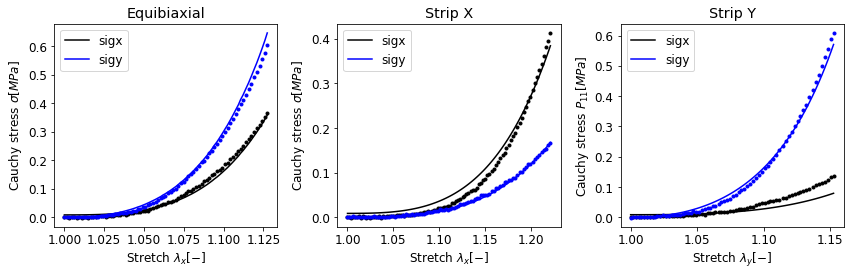

In [31]:
model = CANN_model(*params_cann_all,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [32]:
with open('savednet/CANN_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_cann_all, f)

In [34]:
params_cann_e, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_e)
mdlnumber = 1
params_cann_e, train_loss, val_loss = train_jp(loss_sig_e, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 3.548920e-02
it 2000, train loss = 2.428859e-02
it 3000, train loss = 1.618177e-02
it 4000, train loss = 8.960383e-03
it 5000, train loss = 4.151370e-03
it 6000, train loss = 1.754184e-03
it 7000, train loss = 7.848744e-04
it 8000, train loss = 3.882957e-04
it 9000, train loss = 2.100448e-04
it 10000, train loss = 1.058595e-04
it 11000, train loss = 3.652502e-05
it 12000, train loss = 2.752711e-05
it 13000, train loss = 2.470224e-05
it 14000, train loss = 2.242652e-05
it 15000, train loss = 2.027769e-05
it 16000, train loss = 1.819076e-05
it 17000, train loss = 1.621867e-05
it 18000, train loss = 1.446813e-05
it 19000, train loss = 1.302978e-05
it 20000, train loss = 1.186925e-05
it 21000, train loss = 1.093244e-05
it 22000, train loss = 1.023618e-05
it 23000, train loss = 9.732973e-06
it 24000, train loss = 9.326366e-06
it 25000, train loss = 8.918353e-06
it 26000, train loss = 8.488905e-06
it 27000, train loss = 8.045689e-06
it 28000, train loss = 7.623332e-06
i

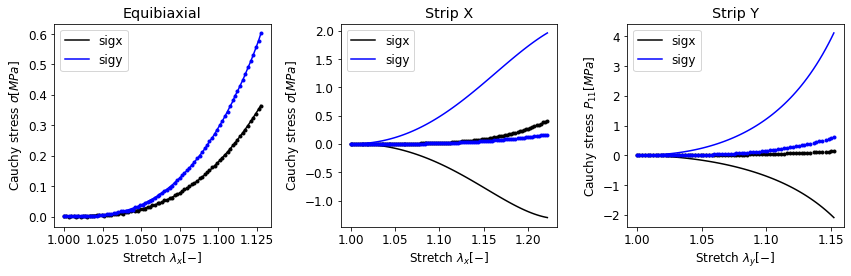

In [35]:
model = CANN_model(*params_cann_e,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [36]:
with open('savednet/CANN_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_cann_e, f)

In [10]:
params_cann_sx, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_sx)
mdlnumber = 1
params_cann_sx, train_loss, val_loss = train_jp(loss_sig_sx, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 1.702384e-02
it 2000, train loss = 9.774074e-03
it 3000, train loss = 7.747104e-03
it 4000, train loss = 5.464699e-03
it 5000, train loss = 3.156451e-03
it 6000, train loss = 1.693739e-03
it 7000, train loss = 9.674260e-04
it 8000, train loss = 6.156593e-04
it 9000, train loss = 4.363965e-04
it 10000, train loss = 3.293819e-04
it 11000, train loss = 2.497865e-04
it 12000, train loss = 1.805881e-04
it 13000, train loss = 1.139937e-04
it 14000, train loss = 5.239552e-05
it 15000, train loss = 1.677232e-05
it 16000, train loss = 6.197642e-06
it 17000, train loss = 4.750974e-06
it 18000, train loss = 4.546183e-06
it 19000, train loss = 4.405259e-06
it 20000, train loss = 4.284368e-06
it 21000, train loss = 4.193618e-06
it 22000, train loss = 4.140817e-06
it 23000, train loss = 4.114194e-06
it 24000, train loss = 4.094625e-06
it 25000, train loss = 4.074115e-06
it 26000, train loss = 4.061141e-06
it 27000, train loss = 4.052905e-06
it 28000, train loss = 4.045438e-06
i

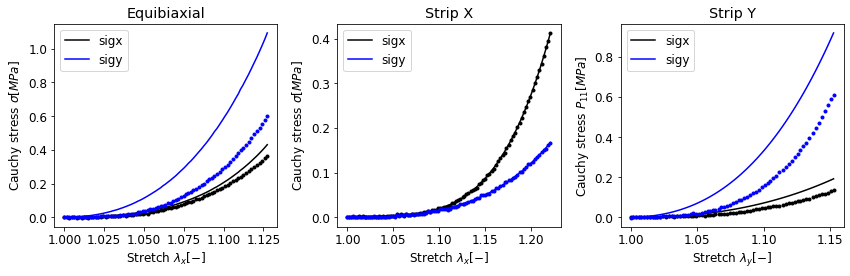

In [39]:
model = CANN_model(*params_cann_sx,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [40]:
with open('savednet/CANN_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_cann_sx, f)

In [42]:
params_cann_sy, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_sy)
mdlnumber = 1
params_cann_sy, train_loss, val_loss = train_jp(loss_sig_sy, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 3.215888e-02
it 2000, train loss = 2.074624e-02
it 3000, train loss = 1.187557e-02
it 4000, train loss = 5.852249e-03
it 5000, train loss = 3.218119e-03
it 6000, train loss = 1.904418e-03
it 7000, train loss = 1.230229e-03
it 8000, train loss = 8.750887e-04
it 9000, train loss = 6.383412e-04
it 10000, train loss = 3.975703e-04
it 11000, train loss = 2.703449e-04
it 12000, train loss = 2.069752e-04
it 13000, train loss = 1.693495e-04
it 14000, train loss = 1.215383e-04
it 15000, train loss = 5.014832e-05
it 16000, train loss = 1.795727e-05
it 17000, train loss = 1.112469e-05
it 18000, train loss = 8.953607e-06
it 19000, train loss = 7.197955e-06
it 20000, train loss = 6.671558e-06
it 21000, train loss = 6.456862e-06
it 22000, train loss = 6.208119e-06
it 23000, train loss = 5.951394e-06
it 24000, train loss = 5.716580e-06
it 25000, train loss = 5.528079e-06
it 26000, train loss = 5.399397e-06
it 27000, train loss = 5.318921e-06
it 28000, train loss = 5.275671e-06
i

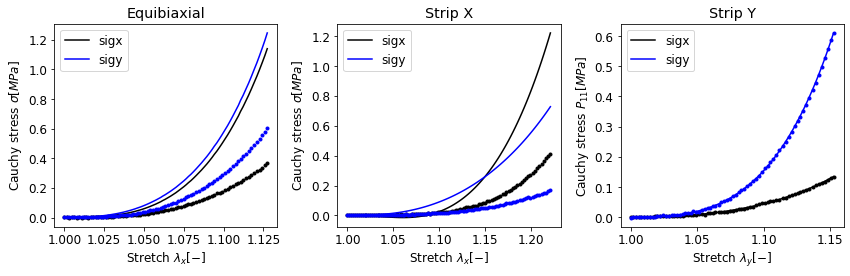

In [43]:
model = CANN_model(*params_cann_sy,normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

fig, ax = plotstresses([lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigmax[0:ind_sx], sigmax[ind_sx:ind_sy], sigmax[ind_sy:]],
                       [sigmay[0:ind_sx], sigmay[ind_sx:ind_sy], sigmay[ind_sy:]],
                       [lambx[0:ind_sx], lambx[ind_sx:ind_sy], lamby[ind_sy:]],
                       [sigx[0:ind_sx], sigx[ind_sx:ind_sy], sigx[ind_sy:]],
                       [sigy[0:ind_sx], sigy[ind_sx:ind_sy], sigy[ind_sy:]])

In [44]:
with open('savednet/CANN_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_cann_sy, f)

# Plot everything

In [6]:
with open('savednet/NODE_skinparams_all.npy', 'rb') as f:
    node_params_a = pickle.load(f)
with open('savednet/NODE_skinparams_equi.npy', 'rb') as f:
    node_params_e = pickle.load(f)
with open('savednet/NODE_skinparams_sx.npy', 'rb') as f:
    node_params_sx = pickle.load(f)
with open('savednet/NODE_skinparams_sy.npy', 'rb') as f:
    node_params_sy = pickle.load(f)

with open('savednet/ICNN_skinparams_all.npy', 'rb') as f:
    icnn_params_a = pickle.load(f)
with open('savednet/ICNN_skinparams_equi.npy', 'rb') as f:
    icnn_params_e = pickle.load(f)
with open('savednet/ICNN_skinparams_sx.npy', 'rb') as f:
    icnn_params_sx = pickle.load(f)
with open('savednet/ICNN_skinparams_sy.npy', 'rb') as f:
    icnn_params_sy = pickle.load(f)

with open('savednet/CANN_skinparams_all.npy', 'rb') as f:
    cann_params_a = pickle.load(f)
with open('savednet/CANN_skinparams_equi.npy', 'rb') as f:
    cann_params_e = pickle.load(f)
with open('savednet/CANN_skinparams_sx.npy', 'rb') as f:
    cann_params_sx = pickle.load(f)
with open('savednet/CANN_skinparams_sy.npy', 'rb') as f:
    cann_params_sy = pickle.load(f)

with open('Data/P12AC1_bsxsy.npy', 'rb') as f:
    lamb, sigma = np.load(f,allow_pickle=True)
lamb_sigma = np.hstack([lamb,sigma])
ind_sx = 81
ind_sy = 182

I1_factor = 5
I2_factor = 7
I4a_factor = 2
I4s_factor = 2
Psi1_factor = 0.5
Psi2_factor = 0.5
Psi4a_factor = 0.5
Psi4s_factor = 0.5
Psi_1_2_factor = 0.5
Psi_1_4a_factor = 0.5
Psi_1_4s_factor = 0.5
Psi_2_4a_factor = 0.5
Psi_2_4s_factor = 0.5
Psi_4a_4s_factor = 0.5
normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,\
                 Psi1_factor,Psi2_factor,Psi4a_factor,Psi4s_factor,\
                 Psi_1_2_factor,Psi_1_4a_factor,Psi_1_4s_factor,\
                 Psi_2_4a_factor,Psi_2_4s_factor, Psi_4a_4s_factor]

params_sx = [cann_params_sx, icnn_params_sx, node_params_sx]
params_e = [cann_params_e, icnn_params_e, node_params_e]
params_sy = [cann_params_sy, icnn_params_sy, node_params_sy]
params_a = [cann_params_a, icnn_params_a, node_params_a]
params_list = [params_sx, params_e, params_sy, params_a]

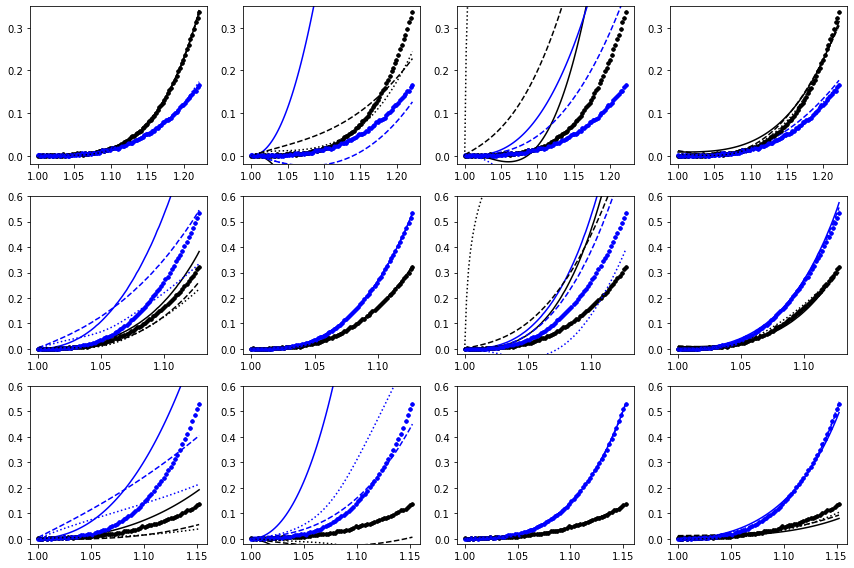

In [24]:
fig, axes = plt.subplots(3,4,figsize=(12,8))
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
panels_list = [['a', 'e', 'i'], ['b', 'f', 'j'], ['c', 'g', 'k'], ['d', 'h', 'l']]

for ax, params, panels in zip(axes.T, params_list, panels_list):
    params_cann, params_icnn, params_node = params

    cann_model = CANN_model(*params_cann, normalization)
    icnn_model = ICNN_model(*params_icnn, normalization)
    node_model = NODE_model(*params_node)

    models = [cann_model, icnn_model, node_model]
    plotstyles = ['-', '--', ':']
    modelnames = ['CANN', 'ICNN', 'NODE']

    for model, modelname, style in zip(models, modelnames, plotstyles):
        indices = [[ind_sx,ind_sy], [0, ind_sx], [ind_sy,lamb.shape[0]]]
        whichlambda = [0,0,1] #because we need to plot strip-y wrt lm_y and the rest wrt lm_x

        sgm_x_pr, sgm_y_pr = eval_Cauchy(lambx, lamby, model, normalization)
        P_x_pr = sgm_x_pr/lambx
        P_y_pr = sgm_y_pr/lamby
        P_x_gt = lamb_sigma[:,2]/lambx
        P_y_gt = lamb_sigma[:,3]/lamby
        ylims = [[-0.020,0.35],[-0.020,0.6],[-0.020,0.6]]
        for axi, (i1,i2), lmid, ylim, panel in zip(ax,indices, whichlambda, ylims, panels):
            lm = lamb_sigma[i1:i2,lmid]
            axi.plot(lm, P_x_gt[i1:i2],'k.',label='$P_x$ Exp.')
            axi.plot(lm, P_y_gt[i1:i2],'b.',label='$P_y$ Exp.')

            axi.plot(lm, P_x_pr[i1:i2],'k'+style, label='$P_x$ '+modelname)
            axi.plot(lm, P_y_pr[i1:i2],'b'+style, label='$P_y$ '+modelname)

            axi.set(ylim=ylim)

            # Save for TikZ
            data = np.array([lm, P_x_gt[i1:i2], P_y_gt[i1:i2]]).T
            columns = ['x', 'P_x_gt', 'P_y_gt']
            df = pd.DataFrame(data, columns = columns)
            df.to_csv('TikZ/fig_skin1_data/data'+'_'+panel+'.csv', index=False, sep=' ')

            data = np.array([lm, P_x_pr[i1:i2], P_y_pr[i1:i2]]).T
            columns = ['x', 'P_x_pr', 'P_y_pr']
            df = pd.DataFrame(data, columns = columns)
            df.to_csv('TikZ/fig_skin1_data/'+modelname+'_'+panel+'.csv', index=False, sep=' ')
# axes[0,0].legend()
fig.tight_layout()
            

# 50 runs

In [7]:
cann_r2 = []
icnn_r2 = []
node_r2 = []
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
for i in range(10):
    print(i)
    mdlnumbers = [1,2,3]
    init_fns = [init_cann, init_icnn, init_node]
    MODELS = [CANN_model, ICNN_model, NODE_model]

    cann_r2i = []
    icnn_r2i = []
    node_r2i = []
    r2lists = [cann_r2i, icnn_r2i, node_r2i]

    for mdlnumber, init_fn, MODEL, r2list in zip(mdlnumbers, init_fns, MODELS, r2lists):
        for loss_fn in ([loss_sig_sx, loss_sig_e, loss_sig_sy, loss_sig_all]):
            key, subkey = random.split(key)
            params, key = init_fn(key)

            opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
            opt_state = opt_init(params)
            params, train_loss, val_loss = train_jp(loss_fn, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000, print_freq=200000)

            #make predictions
            if mdlnumber == 3:
                model = MODEL(*params)
            else:
                model = MODEL(*params, normalization)
            
            indices = [[ind_sx,ind_sy], [0, ind_sx], [ind_sy,lamb.shape[0]]]
            whichlambda = [0,0,1] #because we need to plot strip-y wrt lm_y and the rest wrt lm_x

            sgm_x_pr, sgm_y_pr = eval_Cauchy(lambx, lamby, model, normalization)
            P_x_pr = sgm_x_pr/lambx
            P_y_pr = sgm_y_pr/lamby
            P_x_gt = lamb_sigma[:,2]/lambx
            P_y_gt = lamb_sigma[:,3]/lamby
            for (i1,i2) in indices:
                r2_1 = r2_score(P_x_gt[i1:i2], P_x_pr[i1:i2])
                r2_2 = r2_score(P_y_gt[i1:i2], P_y_pr[i1:i2])
                r2 = 0.5*(r2_1+r2_2)
                r2list.append(r2)
    cann_r2.append(cann_r2i)
    icnn_r2.append(icnn_r2i)
    node_r2.append(node_r2i)

CANN_r2 = np.array(cann_r2)
ICNN_r2 = np.array(icnn_r2)
NODE_r2 = np.array(node_r2)
with open('savednet/CANN_skin_r2_alldata.npy', 'wb') as f:
    pickle.dump(CANN_r2, f)
with open('savednet/ICNN_skin_r2_alldata.npy', 'wb') as f:
    pickle.dump(ICNN_r2, f)
with open('savednet/NODE_skin_r2_alldata.npy', 'wb') as f:
    pickle.dump(NODE_r2, f)

0
1
2
3
4
5
6
7
8
9


In [8]:
CANN_r2 = np.clip(CANN_r2, a_min=0.0, a_max=1.0)
ICNN_r2 = np.clip(ICNN_r2, a_min=0.0, a_max=1.0)
NODE_r2 = np.clip(NODE_r2, a_min=0.0, a_max=1.0)

CANN_r2_mean = np.mean(CANN_r2,axis=0)
CANN_r2_stdv = np.std(CANN_r2,axis=0)

ICNN_r2_mean = np.mean(ICNN_r2,axis=0)
ICNN_r2_stdv = np.std(ICNN_r2,axis=0)

NODE_r2_mean = np.mean(NODE_r2,axis=0)
NODE_r2_stdv = np.std(NODE_r2,axis=0)

# Save for TikZ
xs = [0.0, 1.0, 2.0]
r2_means = [CANN_r2_mean, ICNN_r2_mean, NODE_r2_mean]
r2_stdvs = [CANN_r2_stdv, ICNN_r2_stdv, NODE_r2_stdv]
names = ['CANN', 'ICNN', 'NODE']
for name, x, r2_mean, r2_stdv in zip(names, xs, r2_means, r2_stdvs):
    columns = ['x', 'a', 'e', 'i', 'b', 'f', 'j', 'c', 'g', 'k', 'd', 'h', 'l']
    data = np.expand_dims(np.hstack([x,r2_mean]),axis=0)
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('TikZ/fig_skinR2_data/'+name+'_mean.csv', index=False, sep = ' ')

    data1 = np.expand_dims(np.hstack([x,r2_mean-r2_stdv]),axis=0)
    data2 = np.expand_dims(np.hstack([x,r2_mean+r2_stdv]),axis=0)
    data = np.vstack([data1,data2])
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('TikZ/fig_skinR2_data/'+name+'_stdv.csv', index=False, sep = ' ')

CANN_r2_mean = CANN_r2_mean.reshape([4,3]).T
CANN_r2_stdv = CANN_r2_stdv.reshape([4,3]).T
ICNN_r2_mean = ICNN_r2_mean.reshape([4,3]).T
ICNN_r2_stdv = ICNN_r2_stdv.reshape([4,3]).T
NODE_r2_mean = NODE_r2_mean.reshape([4,3]).T
NODE_r2_stdv = NODE_r2_stdv.reshape([4,3]).T

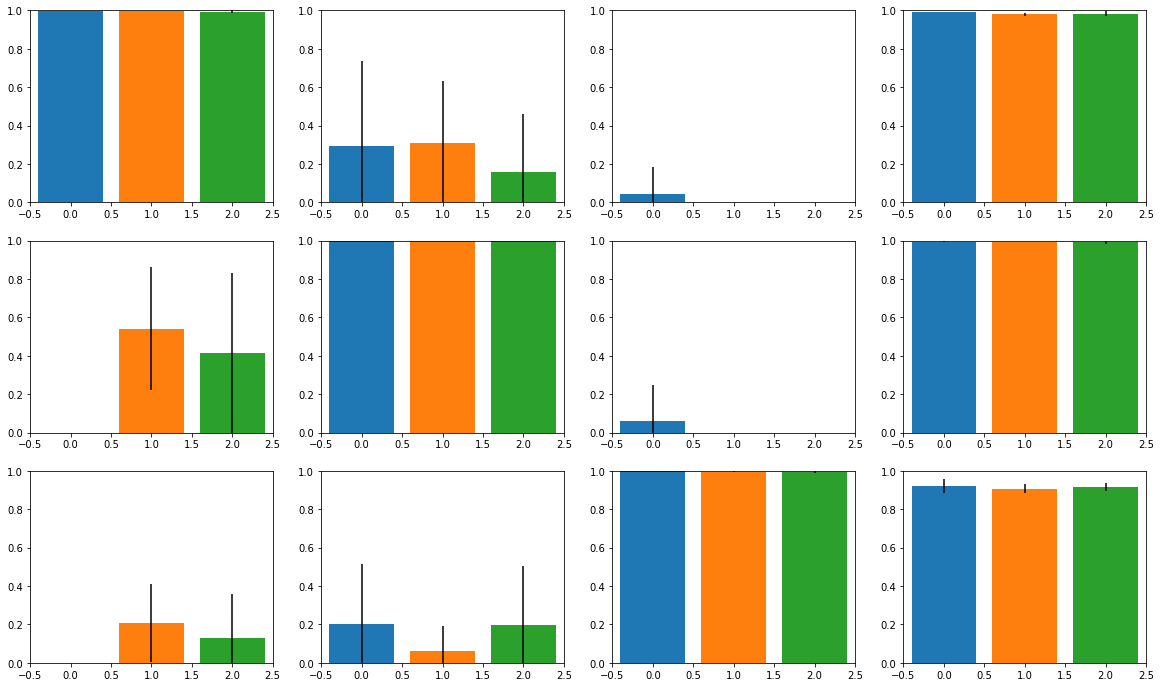

In [10]:
fig, axes = plt.subplots(3,4, figsize=(20,12))

r2_means = [CANN_r2_mean, ICNN_r2_mean, NODE_r2_mean]
r2_stdvs = [CANN_r2_stdv, ICNN_r2_stdv, NODE_r2_stdv]
for x, model_r2_mean, model_r2_stdv in zip(xs, r2_means, r2_stdvs):
    for ax, row_r2_mean, row_r2_stdv in zip(axes, model_r2_mean, model_r2_stdv):
        for axi, r2_mean, r2_stdv in zip(ax, row_r2_mean, row_r2_stdv):
            axi.bar(x, r2_mean)
            axi.errorbar(x, r2_mean, r2_stdv, color='black')
            axi.set(xlim=[-0.5,2.5], ylim=[0,1])

fig.savefig('Figures/fig_skin_R2.jpg')